In [1]:
from rouge_score import rouge_scorer
import numpy as np  
import pandas as pd 
import re     
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as k
k.set_learning_phase(1)
import nltk
from nltk.corpus import stopwords  
from nltk.tokenize import sent_tokenize
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.layers import Dropout, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import initializers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

/N/soft/rhel7/deeplearning/Python-3.10.2/lib/python3.10/site-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [2]:
#Reading the data set and keeping only 150k rows due to computational limitations
train = pd.read_csv("train.csv")
train = train.loc[:150000, :]

In [3]:
train.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [4]:
print(train["article"].head(1).values)
print(train["highlights"].head(1).values)

["By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained

In [5]:
train.shape

(150001, 3)

In [6]:
#Removing the string "(CNN) -- "
str_to_remove = '(CNN) -- '
for i in range(len(train)):
    index = train['article'][i].find(str_to_remove)
    if index != -1:
        train['article'][i] = train['article'][i][index + len(str_to_remove):]


In [7]:
#list of contractions
contraction_mapping = {
                       "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                       "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                       "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                       "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                       "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                       "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                       "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                       "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                       "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                       "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                       "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                       "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                       "you're": "you are", "you've": "you have"
                      }

In [8]:
#Removing contractions from articles and summaries
for i in range(len(train)):
    for word in train['article'][i].split():
        word_lower = word.lower()
        if word_lower in contraction_mapping:
            train['article'][i] = train['article'][i].replace(word, contraction_mapping[word_lower])
    for word in train['highlights'][i].split():
        word_lower = word.lower()
        if word in contraction_mapping:
            train['highlights'][i] = train['highlights'][i].replace(word, contraction_mapping[word_lower])


In [9]:
#Function to remove stopwords
def remove_stopwords(sent, stop):
    sent_new = " ".join([i for i in sent if i not in stop])
    return sent_new

In [10]:
#List of stopwords
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once",
             "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

In [11]:
#Removing punctuations and stopwords from the articles and summaries
new_article = []
new_sum = []

for i in range(len(train)):
    art_without_punc = re.sub(r'[^\w\s]','',train['article'][i])
    clean_article = [remove_stopwords(art_without_punc.split(), stop_words)]
    new_article.append(clean_article)

    sum_without_punc = re.sub(r'[^\w\s]','',train['highlights'][i])
    clean_sum = [remove_stopwords(sum_without_punc.split(), stop_words)]
    new_sum.append(clean_sum)

In [12]:
for i in range(len(new_article)):
    new_article[i] = str(new_article[i])[2:-2]
    new_sum[i] = str(new_sum[i])[2:-2]

In [13]:
train['new_article'] = new_article
train['new_sum'] = new_sum

In [14]:
#Creating a new data frame of article and summary length (by word count)
text_word_count = []
summary_word_count = []

for i in range(len(train['new_article'])):
      text_word_count.append(len(train['new_article'][i].split()))

for i in range(len(train['new_sum'])):
      summary_word_count.append(len(train['new_sum'][i].split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

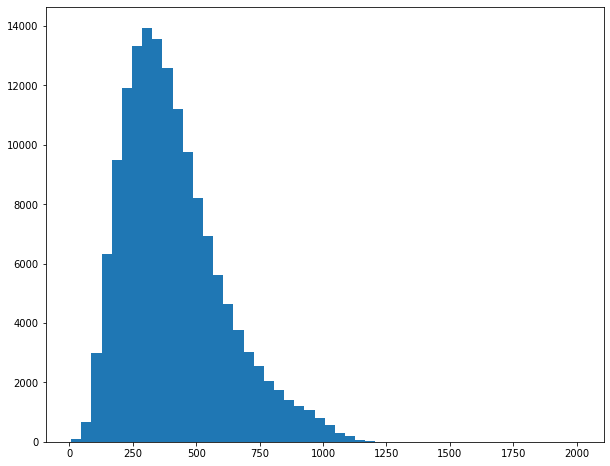

In [15]:
plt.figure(figsize = (10, 8))
plt.hist(length_df['text'], bins = 50)
plt.show()

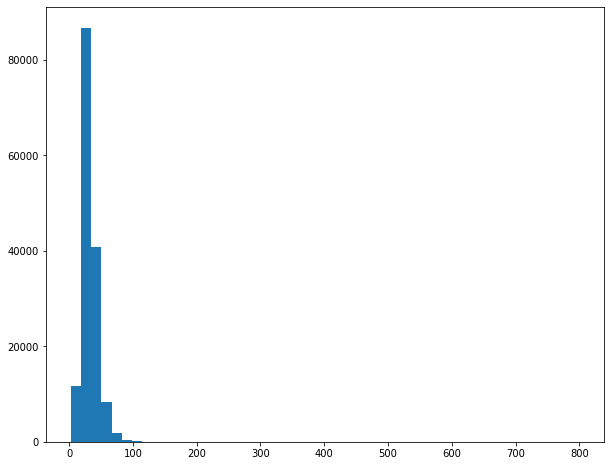

In [16]:
plt.figure(figsize = (10, 8))
plt.hist(length_df['summary'], bins = 50)
plt.show()

In [17]:
max_len_article = 900 #Maximum length of article to keep
max_len_summary = 70 #Maximum length of summary to keep

In [19]:
short_text = []
short_summary = []

# Filtering out the articles with length < max_len_article and summaries with length < max_len_summary
for i in range(len(train)):
    if (len(train['new_article'][i].split()) <= max_len_article and len(train['new_sum'][i].split()) <= max_len_summary):
        short_text.append(train['new_article'][i])
        short_summary.append(train['new_sum'][i])

df = pd.DataFrame({"article": short_text, "summary": short_summary})

In [20]:
#Adding start of string and end of string tokens to summary
df['summary'] = df['summary'].apply(lambda x: 'sostok ' + x + ' eostok')

In [21]:
# Splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['article'], df['summary'], 
                                                  test_size = 0.1, random_state = 42, shuffle = True)

In [22]:
# Tokenizing the article words to integers
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(X_train))

thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value


In [23]:
VOCAB_SIZE = tot_cnt - cnt
art_tokenizer = Tokenizer(num_words= VOCAB_SIZE)
art_tokenizer.fit_on_texts(list(X_train))

# Converting sentences to integer sequences
X_train_seq = art_tokenizer.texts_to_sequences(X_train)
X_val_seq = art_tokenizer.texts_to_sequences(X_val)

# Padding the remaining spaces with 0
X_train = pad_sequences(X_train_seq, maxlen = max_len_article, padding = "post", truncating = "post")
X_val = pad_sequences(X_val_seq, maxlen = max_len_article, padding = "post", truncating = "post")

X_voc_size = len(art_tokenizer.word_index) + 1
X_voc_size # The size of article vocabulary 

475228

In [24]:
# Tokenizing the summary to integers
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

thresh= 6 

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value


In [25]:
VOCAB_SIZE_SUMM = tot_cnt - cnt
sum_tokenizer = Tokenizer(num_words = VOCAB_SIZE_SUMM)
sum_tokenizer.fit_on_texts(list(y_train))

y_train_seq = sum_tokenizer.texts_to_sequences(y_train)
y_val_seq = sum_tokenizer.texts_to_sequences(y_val)

y_train = pad_sequences(y_train_seq, maxlen = max_len_summary, padding = "post", truncating = "post")
y_val = pad_sequences(y_val_seq, maxlen = max_len_summary, padding = "post", truncating = "post")

y_voc_size = len(sum_tokenizer.word_index) + 1
y_voc_size

136401

In [26]:
# Global Attention mechanism class available at
# https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = k.dot(encoder_out_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = k.expand_dims(k.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>', U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = k.tanh(W_a_dot_s + U_a_dot_h)
            if verbose:
                print('Ws+Uh>', Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = k.squeeze(k.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = k.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            assert_msg = "States must be an iterable. Got {} of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            # <= batch_size, hidden_size
            c_i = k.sum(encoder_out_seq * k.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        fake_state_c = k.sum(encoder_out_seq, axis=1)
        fake_state_e = k.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = k.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = k.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [27]:
EMBEDDING_DIM = 500 # Number of dimension for each word vector
HIDDEN_UNITS = 150 # number of hidden units in LSTM cell

In [28]:
# Encoder Layer
encoder_inputs = Input(shape = (max_len_article, ))
# Encoder input embeddings
encoder_embedding = Embedding(X_voc_size, EMBEDDING_DIM)(encoder_inputs)

2022-05-01 22:11:52.493115: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-01 22:11:56.172945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30989 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:b2:00.0, compute capability: 7.0


In [29]:
encoder_embedding

<KerasTensor: shape=(None, 900, 500) dtype=float32 (created by layer 'embedding')>

In [30]:
#Bidirectional Encoder LSTM
encoder_LSTM = LSTM(HIDDEN_UNITS, return_state = True, return_sequences = True)
encoder_LSTM_R = LSTM(HIDDEN_UNITS, return_state = True, go_backwards = True, return_sequences = True)
encoder_outputs_R, state_h_R, state_c_R = encoder_LSTM_R(encoder_embedding)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

final_h = Add()([state_h, state_h_R]) # Hidden States of Bidirectional LSTM
final_c = Add()([state_c, state_c_R]) # Cell States of Bidirectional LSTM
encoder_outputs_final = Add()([encoder_outputs, encoder_outputs_R])
encoder_states = [final_h, final_c]

In [31]:
encoder_outputs_final

<KerasTensor: shape=(None, 900, 150) dtype=float32 (created by layer 'add_2')>

In [32]:
# Decoder Layer
decoder_inputs = Input(shape = (None,))
decoder_emb = Embedding(y_voc_size, EMBEDDING_DIM)
decoder_embedding = decoder_emb(decoder_inputs)

In [33]:
decoder_embedding

<KerasTensor: shape=(None, None, 500) dtype=float32 (created by layer 'embedding_1')>

In [34]:
# Decoder LSTM
decoder_LSTM = LSTM(HIDDEN_UNITS, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout= 0)
decoder_outputs, decoder_fwd, decoder_bwd = decoder_LSTM(decoder_embedding, initial_state = encoder_states)

In [35]:
decoder_outputs

<KerasTensor: shape=(None, None, 150) dtype=float32 (created by layer 'lstm_2')>

In [36]:
# Attention Layer
attn_layer = AttentionLayer(name = 'attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs_final, decoder_outputs])

In [37]:
# Concatenating decoder outputs with attention layer outputs
decoder_concat_input = Concatenate(axis = -1, name = 'concat_layer')([decoder_outputs, attn_out])

In [38]:
decoder_dense = TimeDistributed(Dense(y_voc_size, activation = 'softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [39]:
# Final Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 900)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 900, 500)     237614000   ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 900, 150),   390600      ['embedding[0][0]']              
                                 (None, 150),                                                 

In [41]:
#RMSProp Optimizer with gradient clipping
rmsprop = RMSprop(lr = 0.005, clipvalue = 1.0)
model.compile(optimizer = rmsprop, loss = 'sparse_categorical_crossentropy')

In [42]:
# Training the model
history = model.fit([X_train, y_train[:, :-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:],
                    epochs = 10, batch_size = 128,
                    validation_data = ([X_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))

Epoch 1/10


2022-05-01 22:12:24.344597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8300


1019/1019 [==============================] - 1091s 1s/step - loss: 3.4583 - val_loss: 3.1284
Epoch 2/10
1019/1019 [==============================] - 1070s 1s/step - loss: 3.0478 - val_loss: 2.9877
Epoch 3/10
1019/1019 [==============================] - 1071s 1s/step - loss: 2.8992 - val_loss: 2.9295
Epoch 4/10
1019/1019 [==============================] - 1071s 1s/step - loss: 2.8089 - val_loss: 2.9125
Epoch 5/10
1019/1019 [==============================] - 1071s 1s/step - loss: 2.7429 - val_loss: 2.9032
Epoch 6/10
1019/1019 [==============================] - 1072s 1s/step - loss: 2.6930 - val_loss: 2.9094
Epoch 7/10
1019/1019 [==============================] - 1071s 1s/step - loss: 2.6438 - val_loss: 2.9080
Epoch 8/10
1019/1019 [==============================] - 1071s 1s/step - loss: 2.5985 - val_loss: 2.9159
Epoch 9/10
1019/1019 [==============================] - 1071s 1s/step - loss: 2.5611 - val_loss: 2.9217
Epoch 10/10
1019/1019 [==============================] - 1071s 1s/step - lo

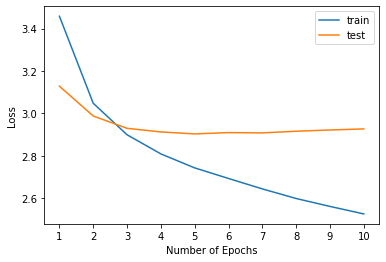

In [43]:
# Plotting the train-test loss curves
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.xticks(ticks = range(10), labels = range(1, 11))
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [44]:
# Creating a reverse mapping from integer to words
reverse_sum_word_index = sum_tokenizer.index_word
reverse_art_word_index = art_tokenizer.index_word
sum_word_index = sum_tokenizer.word_index

In [45]:
# Inference phase
encoder_model_inf = Model(inputs = encoder_inputs, outputs = [encoder_outputs_final, final_h, final_c])

decoder_state_input_h = Input(shape = (HIDDEN_UNITS, ))
decoder_state_input_c = Input(shape = (HIDDEN_UNITS, ))
decoder_hidden_state_input = Input(shape = (max_len_article, HIDDEN_UNITS))
dec_emb2 = decoder_emb(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_LSTM(dec_emb2, initial_state = [decoder_state_input_h, decoder_state_input_c])

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis = -1, name = 'concat')([decoder_outputs2, attn_out_inf])
decoder_outputs2 = decoder_dense(decoder_inf_concat)
decoder_model_inf = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [46]:
# Function to generate summaries using the inference model
def decode_seq(input):
    e_out, e_h, e_c = encoder_model_inf.predict(input)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = sum_word_index['sostok']

    stop_condition = False
    # Final Summary
    decoded_sentence = ''

    while not stop_condition:
        # Passing <sostok> token as first input to decoder for inference
        output_tokens, h, c = decoder_model_inf.predict([target_seq] + [e_out, e_h, e_c])
        
        # Using argmax to select the next word in the summary
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        
        try:
            # Converting the returned integer token to word
            sampled_token = reverse_sum_word_index[sampled_token_index]
        except KeyError:
            continue
        
        if sampled_token != 'eostok':
            decoded_sentence += " "+sampled_token

        if (sampled_token == 'eostok' or len(decoded_sentence.split()) >= max_len_summary - 1):
            stop_condition = True
        target_seq = np.zeros((1, 1))
        
        # Sending the returned integer token as input to the decoder in the next time step
        target_seq[0, 0] = sampled_token_index
        
        # Updating the states of the decoder
        e_h, e_c = h, c

    return decoded_sentence

In [47]:
# Function to print the original summary from integer tokens
def seq2seqsummary(input):
    new_string = ' '
    for i in input:
        if ((i!=0 and i!= sum_word_index['sostok']) and i!= sum_word_index['eostok']):
            try:
                new_string = new_string + reverse_sum_word_index[i] + ' '
            except KeyError:
                continue
    return new_string

#Function to print the original articles from integer tokens
def seq2seqtext(input):
    new_string = ' '
    for i in input:
        if i != 0:
            try:
                new_string = new_string + reverse_art_word_index[i] + ' '
            except KeyError:
                continue
    return new_string


In [48]:
# Generating the predicted summaries
predicted_summary = []
original_summary = []
for i in range(1000):
    pred_sum = decode_seq(X_val[i].reshape(1, max_len_article))
    orig_sum = seq2seqsummary(y_val[i])
    predicted_summary.append(pred_sum)
    original_summary.append(orig_sum)

In [49]:
# Creating a data frame to store the original and predicted summaries
summary_df = pd.DataFrame({"Predicted" : predicted_summary, "Original" : original_summary})
summary_df.to_csv("summary_df_0.005_128_attention.csv")

In [50]:
# Calculating the ROUGE-L score by comparing the predicted and original summaries
scorer_dict = {}
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer = True)
for i in range(len(summary_df)):
    scores = scorer.score(summary_df['Original'][i], summary_df['Predicted'][i])
    scorer_dict[str(i) + '_rougeL'] = scores['rougeL']

In [51]:
# Segregating the ROUGE-L score dictionary
precision_lst = []
recall_lst = []
f1_lst = []

for key in scorer_dict.keys():
    precision_lst.append(scorer_dict[key][0])
    recall_lst.append(scorer_dict[key][1])
    f1_lst.append(scorer_dict[key][2])